# Predicting Emissions Of Buildings In NYC
------

## Contents

__[1. Predictive Models For Green House Gas Emission ](#fourth-bullet)__

- __[Linear Regression ](#model-one)__

- __[General Additive Models](#model-two)__

- __[Gradient Boosted Regression Trees](#model-three)__

__[2. Conclusions And Recommendations ](#fifth-bullet)__


--------------

## Introduction <a class="anchor" id="first-bullet"></a>
-------------
	
I started this project a while back with a goal of taking the 2016 NYC Benchmarking Law data about building energy usage and do something interesting with it. I originally attmpted to clean and analyze this data set to try to find ways to reduce builings' energy usage and subsequently their green house gas emissions. After a few iterations I thought it might be interesting to see if we could additonally predict the emission of green house gases from buildings by looking at their age, energy and water consumption as well as other energy consumption metrics. In the modeling section we look at three different modes for predicting green house gas emissions:

1. Linear Regression

2. Generalized Additive Models

3. Gradient Boosted Regression Trees

In the conclusion section I not only summarize the findings, but give some specific recommendations to reduce the multi-family buildings energy usage.

----------
### Data 
----------
The NYC Benchmarking Law requires owners of large buildings to annually measure their energy and water consumption in a process called benchmarking. The law standardizes this process by requiring building owners to enter their annual energy and water use in the U.S. Environmental Protection Agency's (EPA) online tool, ENERGY STAR Portfolio Manager® and use the tool to submit data to the City. This data gives building owners about a building's energy and water consumption compared to similar buildings, and tracks progress year over year to help in energy efficiency planning.  In this blog post we will analyze how buildings in New York City use energy and water, make recommendations on how to improve their performance and also model their green house gas emissions. The source code for this project can be found <a href="https://github.com/mdh266/NYCBuildingEnergyUse">here</a>.


Benchmarking data is also disclosed publicly and can be found <a href="http://www.nyc.gov/html/gbee/html/plan/ll84_scores.shtml">here</a>.  I analyzed the 2016 data and my summary of the findings and recommendations for reducing energy consumption in New York City buildings are discussed in the conclusions section.

The 2016 data is very messy and a lot of cleaning was necessary to do analysis on it.  One thing to note is that this is **self-reported data**, meaning the performance data wasn't collected by a non-bias third party but by the building owners.  This means our data is biased and we will keep this in mind while performing our analysis.

There are about 13,223 buildings recorded in this dataset and many of them have missing data values. While there are many different techniques for imputing missing values, there was sufficient number of buildings with all their values that I did not need to impute missing values. The cleaning process was made more difficult because the data was stored as strings with multiple non-numeric values which made converting the data to its proper type a more involved process.

In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [6]:
model_dir = "models"
image_dir = "images"

## Predictive Models For Green House Gas Emissions <a class="anchor" id="fourth-bullet"></a>

Now let's build a predictive model for green house gas Emissions by multifamily homes in New York City.  We'll do this at first using a simple linear regression model.  While not the best in terms of perdictive performance it is often a best first step since it allows one to interpet the effect each feature has on the predicted green house gas emissions.  

Before building a model, we first have to prepare our features and scale them appropriately. This involves dictating which are the continuous variabels and the categorical variables.  We define them as,

In [12]:
df = pd.read_csv("data.csv",usecols=['NGI','EI','WI','OPSFT','Age','Site_EUI','Energy_Star','GHGI'])

In [13]:
df2 = df.dropna()

In [14]:
df2.head()

,Energy_Star,Site_EUI,NGI,EI,WI,GHGI,OPSFT,Age
0,0.733998,-0.037249,-0.016434,-0.012849,-0.104832,-0.037384,0.952266,-0.006369
1,0.766809,-0.037921,-0.017372,-0.007096,-0.040264,-0.037782,-1.066019,-0.498512
2,-1.529993,-0.033047,-0.013440,0.019025,-0.047608,-0.031731,-0.571388,-0.357899
12,-1.628428,-0.032134,-0.013440,0.026273,-0.046640,-0.031098,-1.354886,-1.342186
14,-1.398747,-0.030127,-0.011905,-0.001617,-0.051331,-0.032060,-1.148160,-1.342186


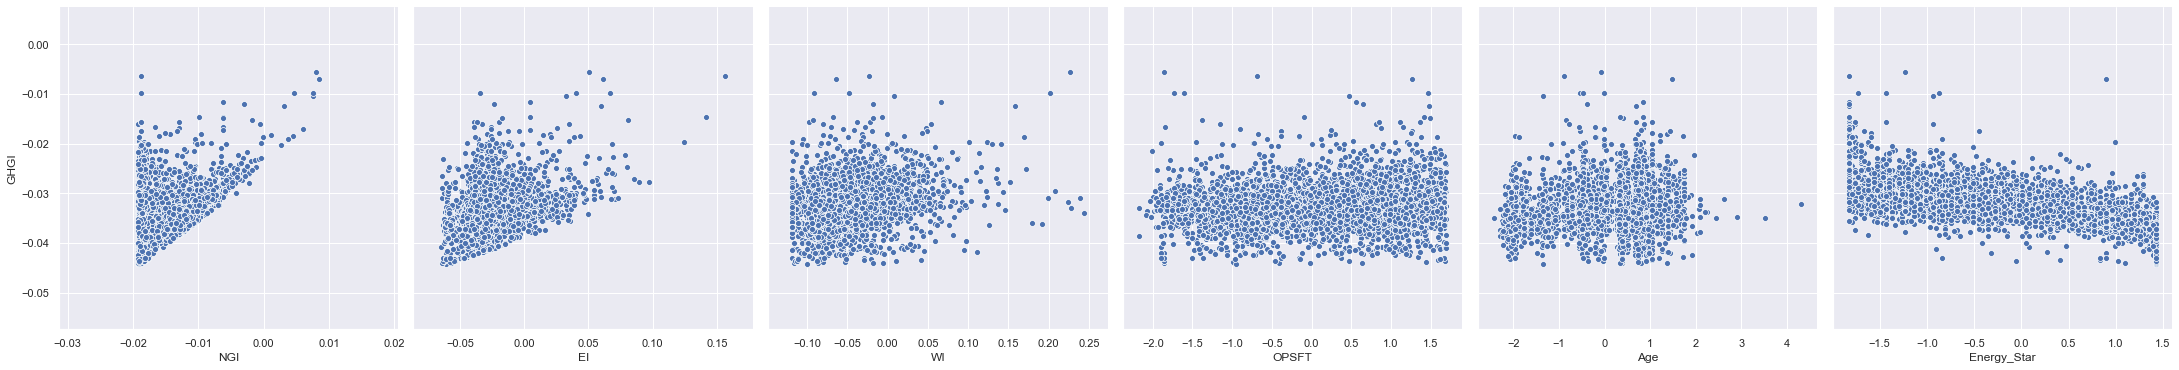

In [15]:
# plot the residuals
sns.pairplot(df2, 
             x_vars=['NGI','EI','WI','OPSFT','Age','Energy_Star'], 
             y_vars='GHGI', 
             kind = 'scatter',
             size=5, 
             dropna=True)

In [16]:
X,Y = df2.drop(["GHGI","Site_EUI"],axis=1),df2["GHGI"]

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


### Linear Regression <a class="anchor" id="model-one"></a>

As we stated early we'll start out with a <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">Linear Regression Model</a> since it is simple and interpertable. The form of a linear regression the model assumes that the green hour gas emission intensity (`GHGI`) labeld $y$, can be expressed a linear combination,

$$ y \; = \; \theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} +  \ldots + \theta_{p} x_{p} + \epsilon$$


The $x_{i}$'s are the features for our model (`WI`, `OPSFT`, etc), and the error $\epsilon \sim N(0,\sigma^{2}$) is normally distributed.  We then make a model $h_{\theta}(\textbf{x})$,

$$ h_{\theta}(\textbf{x}) \; = \; \theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} +  \ldots + \theta_{p} x_{p} $$

And estimate the coefficents ($\theta_{i}$) are estimated using ordinary least squares methods.  This leads to the expected value of our preditions being unbiased:

$$ E[ h_{\theta}(\textbf{x})] \; = \; \theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} +  \ldots + \theta_{p} x_{p} $$

We can easily implement a least squares regression model using Scikit-learn:

In [83]:
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model    import Ridge
from sklearn.metrics         import r2_score
from sklearn.model_selection import GridSearchCV

model1 = Pipeline(steps = [('scaler',StandardScaler()),
                           ('reg',Ridge())])

params = {'reg__alpha': [0.0, 0.1, 0.2, 0.3, 0.5, 1, 1.2, 1.5, 2.0],
          'reg__fit_intercept' : [False, True]}

grid   = GridSearchCV(model1,
                      params,
                      'r2',
                      cv=5
                      )
grid.fit(X_train, y_train)

# score = model1.score(X_train, y_train)
# # Explained variance score: 
# print("Variance score: {}".format(score))

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('reg',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'reg__alpha': [0.0, 0.1, 0.2, 0.3, 0.5, 1, 1.2, 1.5,
                                        2.0],
                         'reg__fit_intercep

In [85]:
grid.cv_results_

{'mean_fit_time': array([0.00751853, 0.00745401, 0.00518174, 0.00467639, 0.00462637,
        0.00478625, 0.00515351, 0.00463352, 0.00457921, 0.00481553,
        0.00475893, 0.00492492, 0.00512433, 0.0054944 , 0.00491738,
        0.00481019, 0.00473127, 0.00508728]),
 'std_fit_time': array([1.10004263e-03, 1.32729080e-03, 7.66909913e-04, 8.35509872e-05,
        1.65748116e-04, 1.64449792e-04, 8.31710788e-04, 9.33992421e-06,
        1.24772859e-04, 3.43211653e-04, 1.38824864e-04, 1.35775192e-04,
        2.12018713e-04, 5.01956500e-04, 2.70820838e-05, 1.27832616e-04,
        1.17852173e-04, 1.74994599e-04]),
 'mean_score_time': array([0.00266581, 0.00299702, 0.00167785, 0.00157018, 0.00154672,
        0.0015924 , 0.00166826, 0.00155797, 0.00154719, 0.00157323,
        0.00203137, 0.00155373, 0.00169573, 0.00162125, 0.00157657,
        0.00171423, 0.00155635, 0.00158062]),
 'std_score_time': array([1.69130544e-04, 7.55957569e-04, 1.23685033e-04, 5.39265512e-05,
        1.20580417e-05, 7.02

In [87]:
params = grid.cv_results_["params"]
scores = grid.cv_results_['mean_test_score']
stds   = grid.cv_results_['std_test_score']
ranks  = grid.cv_results_['rank_test_score']

In [107]:
exp_id = mlflow.create_experiment("Ridge Regression 2")

In [102]:

def log_run(exp_id, param, score, std, rank):
    with mlflow.start_run(experiment_id=exp_id, nested=True) as run:
        mlflow.log_params(param)
        mlflow.log_metric('mean_r2', score)
        mlflow.log_metric('std_r2',  std)
        mlflow.log_metric('rank',    rank)


In [108]:
for i in range(len(params)):
    log_run(exp_id, params[i], scores[i], stds[i], ranks[i])

In [121]:
params = grid.best_params_
score  = grid.best_score_

In [124]:
coefs = dict(zip(X_train.columns,grid.best_estimator_['reg'].coef_))

In [125]:
coefs

{'Energy_Star': -0.002648678649573547,
 'NGI': -0.0001763397632395694,
 'EI': 0.0002225744391226211,
 'WI': 0.0006688899897229495,
 'OPSFT': 0.00031359895380051974,
 'Age': 0.0006900809244867454}

In [127]:
model = grid.best_estimator_

In [134]:
X_test['y_pred'] = model.predict(X_test)

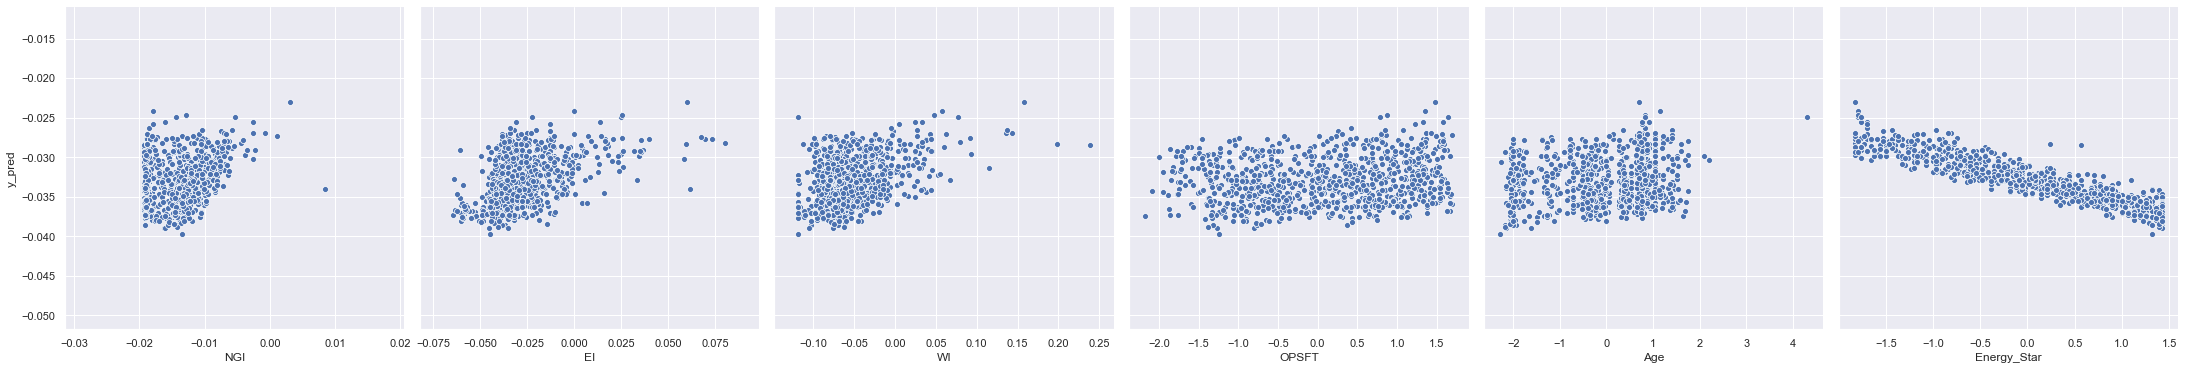

In [136]:
# plot the residuals
fig = sns.pairplot(X_test,
             x_vars=['NGI','EI','WI','OPSFT','Age','Energy_Star'], 
             y_vars='y_pred',
             kind = 'scatter',
             size=5, 
             dropna=True)

In [137]:
fig.savefig("pred.png")

In [138]:
with mlflow.start_run(experiment_id=exp_id, run_name='BEST',nested=True) as run:
        mlflow.log_params(params)
        mlflow.log_metric('mean_r2', score)
        mlflow.set_tags(coefs)
        mlflow.log_artifact("pred.png")

![ds](images/MLFLOW1.png)

![som](images/Runexample.png)